In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
# from matplotlib.ticker import FormatStrFormatter
import string
import glasbey
import seaborn as sns

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.plotting import plot_tsne_colors, plot_label_tags, plot_squared_brackets
from text_embeddings_src.scalebars import add_scalebar_frac

In [ ]:
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path(
    "../../results/figures/updated_dataset/final_figures/ecml_submission"
)
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2025-03-12 11:28:48CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.31.0

transformers: 4.45.2
openTSNE    : 1.0.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

numpy              : 1.26.4
pandas             : 2.2.3
matplotlib         : 3.9.2
jupyter_black      : 0.4.0
seaborn            : 0.13.2
glasbey            : 0.2.1
distro             : 1.9.0
memory_profiler    : 0.61.0
text_embeddings_src: 0.0.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Figure 1

In [ ]:
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 8

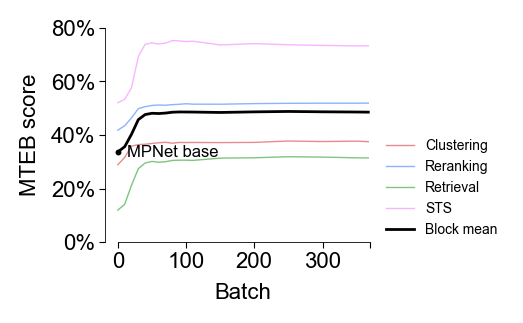

In [ ]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(2.5, 1.5), dpi=200, layout="constrained")

# load
## mpnet crops
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
df_training_eval_results = pd.read_parquet(
    variables_path / saving_path / "df_training_eval_results_mteb_batches_v2",
    engine="pyarrow",
)

df_training_eval_results.set_index("batch", inplace=True)

# calculate block means
df_block_mean = pd.DataFrame()
df_block_mean["clustering"] = df_training_eval_results[
    [
        "ArxivClusteringP2P",
        "BiorxivClusteringP2P",
        "MedrxivClusteringP2P",
        "RedditClusteringP2P",
        "StackExchangeClusteringP2P",
    ]
].mean(axis=1)

df_block_mean["reranking"] = df_training_eval_results[
    ["SciDocsRR", "MindSmallReranking"]
].mean(axis=1)
df_block_mean["retrieval"] = df_training_eval_results[
    ["SCIDOCS", "ArguAna"]
].mean(axis=1)
df_block_mean["sts"] = df_training_eval_results[
    ["STS15", "STS16", "STSBenchmark"]
].mean(axis=1)

# create palette
palette = glasbey.create_palette(
    palette_size=len(df_training_eval_results.columns),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)


for i, elem in enumerate(df_block_mean.columns):
    ax.plot(
        df_block_mean.index,
        df_block_mean[elem],
        label=[elem.upper() if elem == "sts" else elem.capitalize()],
        c=palette[i],
        alpha=0.5,
    )


ax.plot(
    df_block_mean.index,
    df_block_mean.mean(axis=1),
    label="Block mean",
    c="k",
    lw=1,
)

ax.scatter(0, df_block_mean.mean(axis=1).iloc[0], c="k", s=5)
ax.text(
    14,
    df_block_mean.mean(axis=1).iloc[0],
    f"MPNet base",
    # fontsize=5,
    va="center",
    ha="left",
)

ax.legend(loc=(1, 0))
ax.set_ylim(0, 0.8)
ax.set_xticks([0, 100, 200, 300, 370])
ax.set_xticklabels([0, 100, 200, 300, ""])
ax.set_xlabel("Batch")
ax.set_ylabel("MTEB score")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.spines.bottom.set_bounds(0, 370)

fig.savefig(figures_path / "figure1_ecml_v1.png")
fig.savefig(figures_path / "figure1_ecml_v1.pdf")

# Figure 2

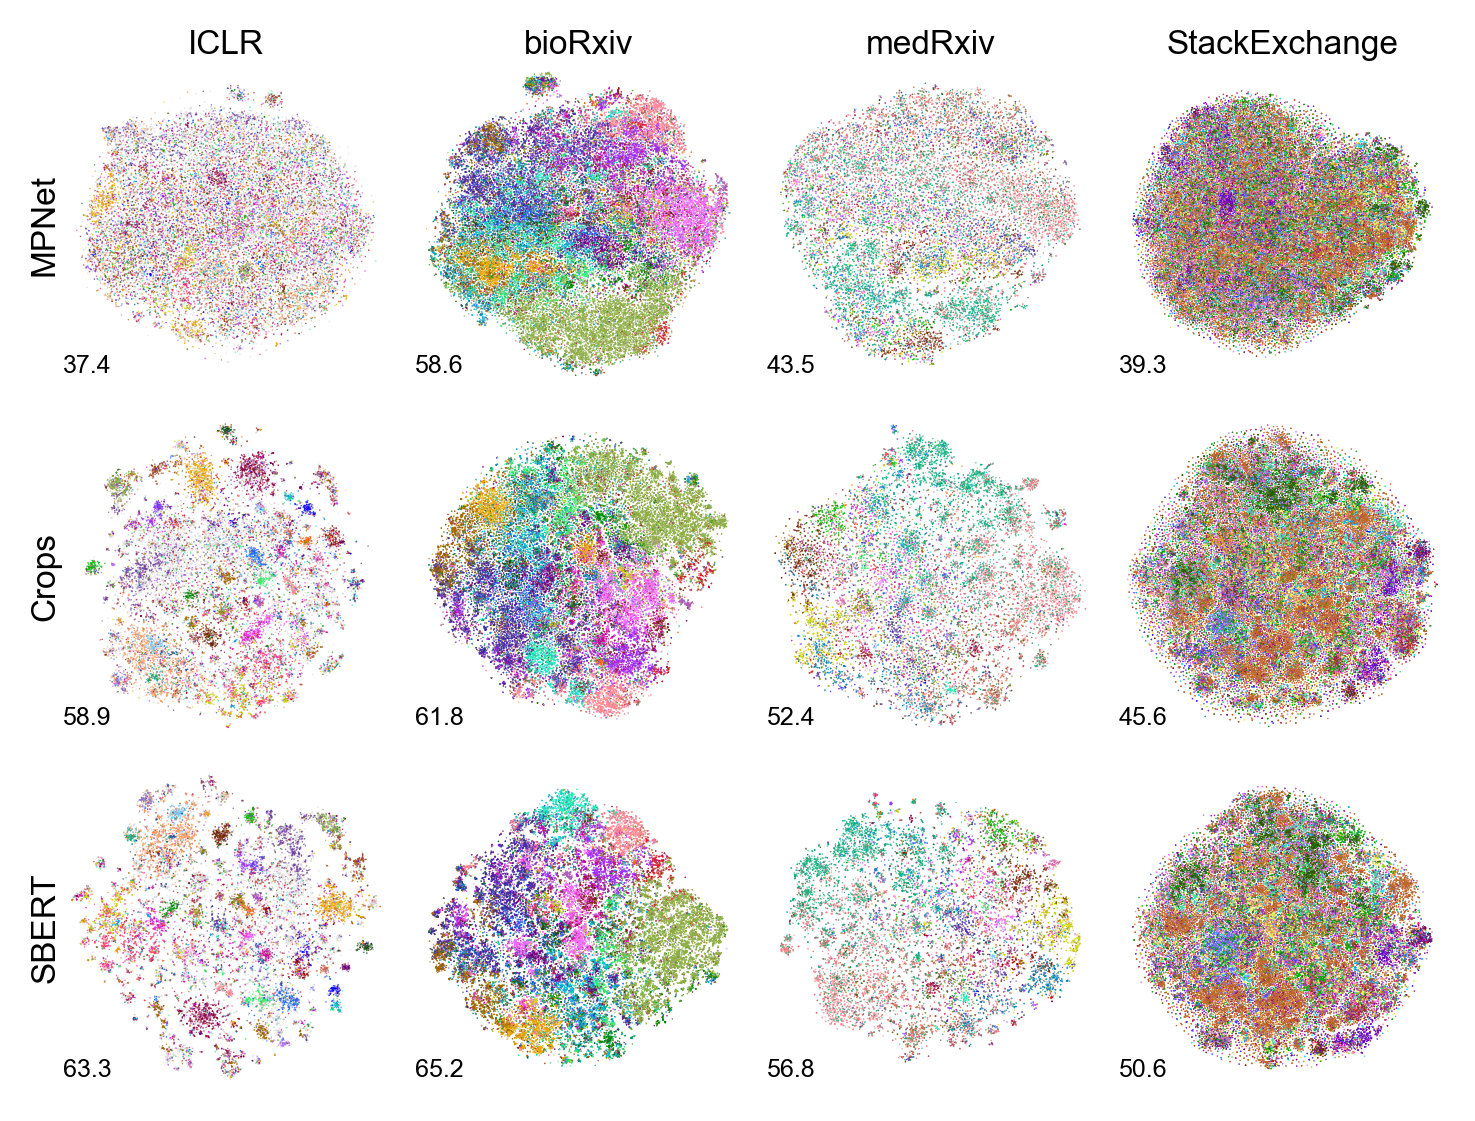

In [ ]:
datasets_names = ["ICLR", "biorxiv", "medrxiv", "stackexchange"]
datasets_titles = ["ICLR", "bioRxiv", "medRxiv", "StackExchange"]
reps = ["MPNet", "Crops", "SBERT"]

cm = 1 / 2.54

fig, axs = plt.subplots(
    len(reps),
    len(datasets_names),
    figsize=(12.2 * cm, 9.2 * cm),
    dpi=300,
    layout="constrained",
)

for i, dataset_name in enumerate(datasets_names):
    if (i == 0) | (i == 2) | (i == 3):
        plot_type = "subplot_2"
    else:
        plot_type = "subplot_2"

    ### ICLR
    if i == 0:
        ## MPNEt
        saving_path = Path("embeddings_mpnet") / Path("updated_dataset")
        tsne_mpnet = np.load(variables_path / saving_path / "tsne_av.npy")
        ## Crops
        tsne_crops = np.load(
            variables_path
            / saving_path
            / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
        )
        ## SBERT
        ## tsnes
        saving_path = Path("embeddings_sbert") / Path("updated_dataset")
        tsne_sbert = np.load(variables_path / saving_path / "tsne_av.npy")
        ## accuracies
        knn_acc_highd = np.load(
            variables_path / "updated_dataset" / "knn_accuracy_sbert.npy"
        )

        tsnes = [tsne_mpnet, tsne_crops, tsne_sbert]
        knn_accs = [0.374, 0.589, knn_acc_highd[0]]

        colors = np.load(
            variables_path / "updated_dataset" / "colors_iclr.npy"
        )
    else:
        ### MTEB

        # LOAD
        ## SBERT
        saving_path = Path("embeddings_sbert") / Path(
            f"updated_dataset/mteb_datasets/{dataset_name}"
        )
        tsne_sbert = np.load(
            variables_path / saving_path / "tsne_av.npy",
        )
        knn_acc_sbert = np.load(
            variables_path / saving_path / "knn_accuracies_baseline.npy",
        )[0]
        ## MPNet
        saving_path = Path("embeddings_mpnet") / Path(
            f"updated_dataset/mteb_datasets/{dataset_name}"
        )
        tsne_mpnet = np.load(
            variables_path / saving_path / "tsne_av.npy",
        )
        knn_acc_mpnet = np.load(
            variables_path / saving_path / "knn_accuracies_baseline.npy",
        )[0]
        ## Crops
        tsne_crops = np.load(
            variables_path
            / saving_path
            / "tsne_av_after_training_av_1_epoch.npy",
        )
        knn_acc_crops = np.load(
            variables_path / saving_path / "knn_accuracies_run1.npy",
        )[0][0]

        tsnes = [tsne_mpnet, tsne_crops, tsne_sbert]
        knn_accs = [knn_acc_mpnet, knn_acc_crops, knn_acc_sbert]

        ## Colors
        colors = np.load(
            variables_path / "updated_dataset" / f"colors_{dataset_name}.npy"
        )

    # PLOT
    for j, tsne in enumerate(tsnes):
        if j == 0:
            axs[j, i].set_title(
                datasets_titles[i], va="center"
            )  # fontsize=15,
        if i == 0:
            axs[j, i].text(
                -0.1,
                0.5,
                reps[j],
                transform=axs[j, i].transAxes,
                rotation="vertical",
                va="center",
                fontsize=8,
            )

        plot_tsne_colors(tsne, colors, ax=axs[j, i], plot_type=plot_type)

        axs[j, i].text(
            0,
            0.03,
            f"{knn_accs[j]*100:.1f}",
            transform=axs[j, i].transAxes,
            va="bottom",
            ha="left",
            # size=10,
        )
        axs[j, i].axis("equal")


fig.savefig(
    figures_path
    / f"figure2_ecml_v1.png"  # tsne_embeddings_mteb_datasets_with_knn_accs_v6
)

fig.savefig(figures_path / f"figure2_ecml_v1.pdf")

# Figure 3

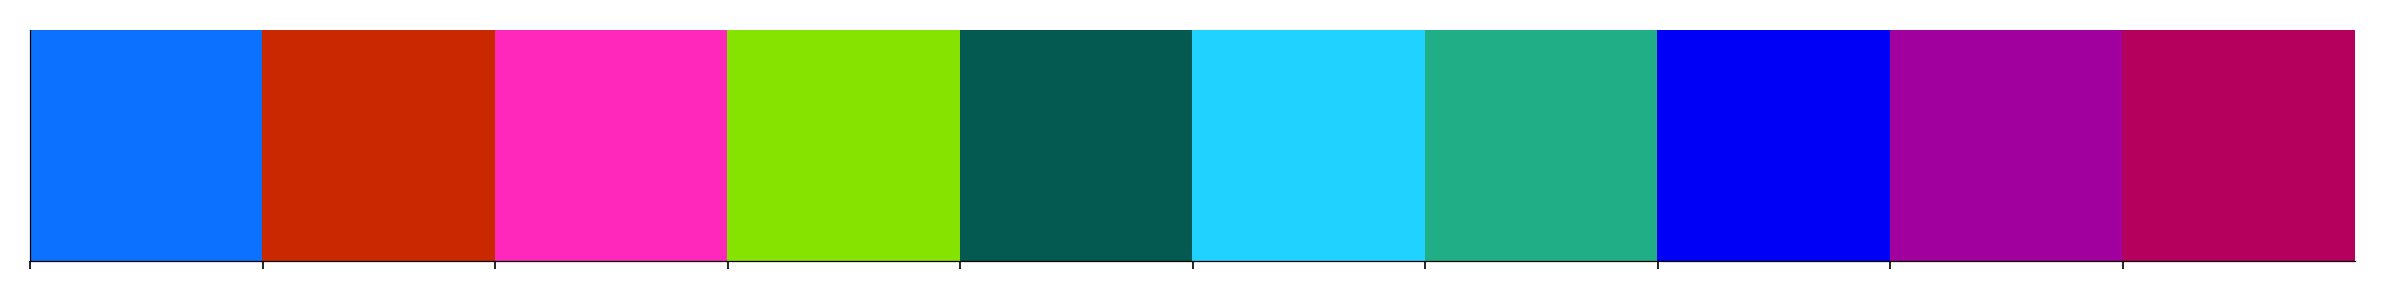

In [ ]:
%matplotlib inline

# old one
palette = glasbey.create_palette(
    palette_size=10,
    lightness_bounds=(20, 75),
    chroma_bounds=(30, 90),
    colorblind_safe=True,
)
sns.palplot(palette)

In [ ]:
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 8

<>:100: SyntaxWarning: invalid escape sequence '\D'
<>:105: SyntaxWarning: invalid escape sequence '\D'
<>:113: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:148: SyntaxWarning: invalid escape sequence '\D'
<>:175: SyntaxWarning: invalid escape sequence '\D'
<>:100: SyntaxWarning: invalid escape sequence '\D'
<>:105: SyntaxWarning: invalid escape sequence '\D'
<>:113: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:148: SyntaxWarning: invalid escape sequence '\D'
<>:175: SyntaxWarning: invalid escape sequence '\D'
<unknown>:100: SyntaxWarning: invalid escape sequence '\D'
<unknown>:105: SyntaxWarning: invalid escape sequence '\D'
<unknown>:113: SyntaxWarning: invalid escape sequence '\D'
<unknown>:121: SyntaxWarning: invalid escape sequence '\D'
<unknown>:148: SyntaxWarning: invalid escape sequence '\D'
<unknown>:175: SyntaxWarning: invalid escape sequence '\D'
<unknown>:100: SyntaxW

340
$\Delta_{D_3}$ 5.3
$\Delta_S$ 14.7


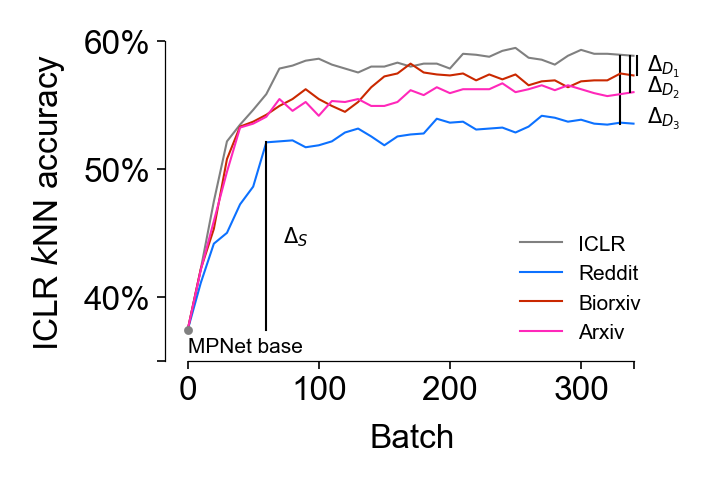

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2.25, 1.5), dpi=300, layout="constrained")

model_name = "MPNet"

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)
## iclr
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)

## reddit
knn_accuracies_iclr_train_reddit = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_reddit_eval_iclr_v3.npy",
)

## biorxiv
knn_accuracies_iclr_train_biorxiv = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_biorxiv_eval_iclr_v1.npy",
)

## arxiv
knn_accuracies_iclr_train_arxiv = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_arxiv_eval_iclr_v1.npy",
)


last_x_1 = np.arange(len(knn_accuracies_iclr_train_arxiv))[-1] * 10
print(last_x_1)

# cut them
knn_accuracies_iclr = knn_accuracies_iclr[
    : len(knn_accuracies_iclr_train_arxiv)
]
knn_accuracies_iclr_train_reddit = knn_accuracies_iclr_train_reddit[
    : len(knn_accuracies_iclr_train_arxiv)
]
knn_accuracies_iclr_train_biorxiv = knn_accuracies_iclr_train_biorxiv[
    : len(knn_accuracies_iclr_train_arxiv)
]
knn_accuracies_iclr_train_arxiv = knn_accuracies_iclr_train_arxiv[
    : len(knn_accuracies_iclr_train_arxiv)
]

last_knn_acc_iclr = np.vstack(knn_accuracies_iclr)[:, 0][-1]


## ICLR
ax.plot(
    np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="grey",
)


## REDDIT
# last_x_1 = np.arange(len(knn_accuracies_iclr_train_reddit))[-1] * 10
# print(last_x_1)

# first half
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_reddit)) * 10,
    np.vstack(knn_accuracies_iclr_train_reddit)[:, 0],
    label="Reddit",
    c=palette[0],
)

## delta
last_value = np.vstack(knn_accuracies_iclr_train_reddit)[:, 0][-1]
ax.plot(
    np.array([last_x_1, last_x_1]) - 10, [last_knn_acc_iclr, last_value], c="k"
)
ax.text(
    last_x_1 + 10,
    0.54,  # last_value + (last_knn_acc_iclr - last_value) / 2,
    "$\Delta_{D_3}$",  # = ${(last_knn_acc_iclr-last_value)*100:.1f}",
    fontsize=5,
    va="center",
    ha="left",
)
print("$\Delta_{D_3}$", np.round((last_knn_acc_iclr - last_value) * 100, 1))
## sentence delta
ax.plot(
    np.array([70, 70]) - 10,
    [knn_acc_highd[0], np.vstack(knn_accuracies_iclr_train_reddit)[6, 0]],
    c="k",
)
print(
    "$\Delta_S$",
    np.round(
        (np.vstack(knn_accuracies_iclr_train_reddit)[6, 0] - knn_acc_highd[0])
        * 100,
        1,
    ),
)
ax.text(
    70 + 3,
    knn_acc_highd[0]
    + (np.vstack(knn_accuracies_iclr_train_reddit)[6, 0] - knn_acc_highd[0])
    / 2,
    f"$\Delta_S$",
    fontsize=5,
    va="center",
    ha="left",
)


## BIORXIV
# last_x_1 = np.arange(len(knn_accuracies_iclr_train_biorxiv))[-1] * 10
# print(last_x_1)

# first half
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_biorxiv)) * 10,
    np.vstack(knn_accuracies_iclr_train_biorxiv)[:, 0],
    label="Biorxiv",
    c=palette[1],
)

## delta
last_value = np.vstack(knn_accuracies_iclr_train_biorxiv)[:, 0][-1]
ax.plot(
    np.array([last_x_1, last_x_1]) + 3, [last_knn_acc_iclr, last_value], c="k"
)
ax.text(
    last_x_1 + 10,
    last_value + (last_knn_acc_iclr - last_value) / 2,
    "$\Delta_{D_1}$",  # = ${(last_knn_acc_iclr-last_value)*100:.1f}",
    fontsize=5,
    va="center",
    ha="left",
)


## ARXIV
# last_x_1 = np.arange(len(knn_accuracies_iclr_train_arxiv))[-1] * 10
# print(last_x_1)

# first half
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_arxiv)) * 10,
    np.vstack(knn_accuracies_iclr_train_arxiv)[:, 0],
    label="Arxiv",
    c=palette[2],
)

## delta
last_value = np.vstack(knn_accuracies_iclr_train_arxiv)[:, 0][-1]
ax.plot(
    np.array([last_x_1, last_x_1]) - 3, [last_knn_acc_iclr, last_value], c="k"
)
ax.text(
    last_x_1 + 10,
    last_value + (last_knn_acc_iclr - last_value) / 2,
    "$\Delta_{D_2}$",  # = ${(last_knn_acc_iclr-last_value)*100:.1f}",
    fontsize=5,
    va="top",
    ha="left",
)


## scatter point
ax.scatter(0, knn_acc_highd[0], c="grey", s=5, zorder=5)
ax.text(
    0,
    knn_acc_highd[0] - 0.005,
    f"MPNet base",
    fontsize=5,
    va="top",
    ha="left",
)

ax.legend(loc="lower right")
## y axis
ax.set_ylabel("ICLR $k$NN accuracy")
y_lim_bottom = 0.35
y_lim_top = 0.6
ax.set_ylim(y_lim_bottom, y_lim_top)
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_yticks([0.35, 0.4, 0.5, 0.6])
ax.set_yticklabels(["", "40%", "50%", "60%"])

ax.spines.left.set_bounds(y_lim_bottom, 0.6)
## x axis
ax.set_xlabel("Batch")
ax.set_xticks([0, 100, 200, 300, last_x_1])
ax.set_xticklabels([0, 100, 200, 300, ""])
ax.spines.bottom.set_bounds(
    0,
    last_x_1,
)


fig.savefig(figures_path / "figure3_ecml_v2.png")
fig.savefig(figures_path / "figure3_ecml_v2.pdf")

# Figure 4

In [ ]:
# mpl.rcParams["xtick.labelsize"] = 8
# mpl.rcParams["ytick.labelsize"] = 8
# mpl.rcParams["axes.labelsize"] = 8

In [ ]:
# tab10 colors
tab10_colors = {
    "tab:blue": "#1f77b4",
    "tab:orange": "#ff7f0e",
    "tab:green": "#2ca02c",
    "tab:red": "#d62728",
    "tab:purple": "#9467bd",
    "tab:brown": "#8c564b",
    "tab:pink": "#e377c2",
    "tab:gray": "#7f7f7f",
    "tab:olive": "#bcbd22",
    "tab:cyan": "#17becf",
}

tab10_colors_light = {
    "tab:blue": "#7fbee9",
    "tab:orange": "#ffbf86",
    "tab:green": "#87de87",
    "tab:red": "#eb9293",
    "tab:purple": "#c9b3de",
    "tab:brown": "#cca69f",
    "tab:pink": "#f1bbe0",
    "tab:gray": "#bfbfbf",
    "tab:olive": "#e8e985",
    "tab:cyan": "#81e7f1",
}

In [ ]:
12.2 / 7.2 * 2

3.3888888888888884

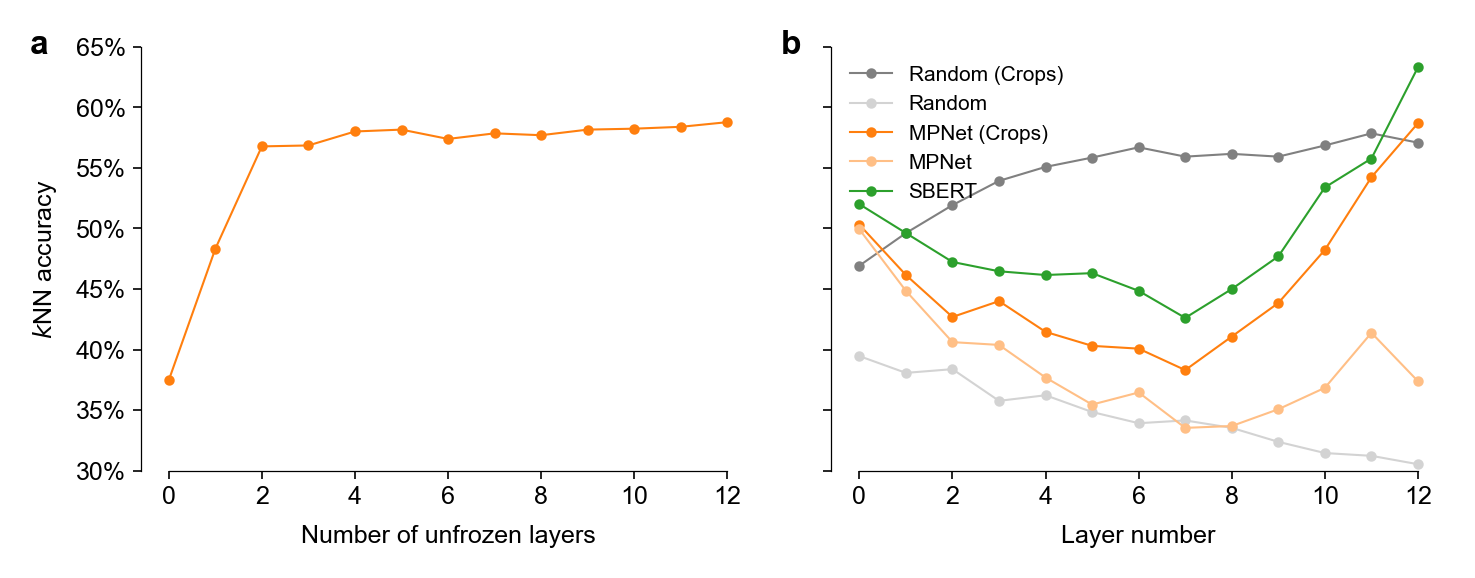

In [ ]:
%matplotlib inline

cm = 1 / 2.54


fig, axs = plt.subplots(
    1,
    2,
    figsize=(12.2 * cm, 4.6 * cm),
    dpi=300,
    layout="constrained",
    sharey=True,
)

txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

fntsz = 8

model_name = "MPNet"
knn_accs_all = []
for first_unfrozen_layer in np.flip(np.arange(13)):
    ## save losses and accuracies
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("freezing_experiment")
    )

    saving_name_accuracies = Path(
        "knn_accuracies_first_unfrozen_layer_"
        + str(first_unfrozen_layer)
        + "_v1.npy"
    )

    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies,
    )

    knn_accs_all.append(knn_accuracies[0, 0])

axs[0].plot(
    np.arange(13), knn_accs_all, c="tab:orange", marker=".", ms=3  # "k",
)
## x-axis
axs[0].set_xlabel("Number of unfrozen layers")  # , fontsize=fntsz)
axs[0].set_xticks(np.arange(0, 14, 2))
axs[0].spines.bottom.set_bounds(0, 12)
## y-axis
axs[0].set_ylim(0.3, 0.65)
axs[0].set_ylabel("$k$NN accuracy")  # , fontsize=fntsz)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].spines.left.set_bounds(0.3, 0.65)
axs[0].text(
    -0.15,
    1.04,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)


# panel b
knn_acc_after_all_mpnet = []
knn_acc_before_all_mpnet = []
knn_acc_before_all_sbert = []
knn_acc_before_all_random = []
knn_acc_after_all_random = []
knn_acc_after_10_all_random = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # load random BERT
    model_name = "random_bert"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_10_random = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])
    knn_acc_before_all_random.append(knn_acc_before_random[0])
    knn_acc_after_all_random.append(knn_acc_after_random[0])
    knn_acc_after_10_all_random.append(knn_acc_after_10_random[0])

axs[1].plot(
    np.arange(13),
    knn_acc_after_10_all_random,
    c="grey",
    ms=3,
    marker=".",
    label="Random (Crops)",
)
axs[1].plot(
    np.arange(13),
    knn_acc_before_all_random,
    c="lightgrey",
    ms=3,
    marker=".",
    label="Random",
)
# axs[1].plot(
#     np.arange(13),
#     knn_acc_after_all_random,
#     c="grey",
#     ms=3,
#     marker=".",
#     label=" Random (after 1 epoch)",
# )

axs[1].plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c=tab10_colors["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet (Crops)",
)

axs[1].plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c=tab10_colors_light["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet",
)


axs[1].plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c="tab:green",  # tab10_colors_light["tab:green"],
    ms=3,
    marker=".",
    label="SBERT",
)
## x-axis
axs[1].set_xlabel("Layer number")  # , fontsize=fntsz)
axs[1].set_xticks(np.arange(0, 14, 2))
axs[1].spines.bottom.set_bounds(0, 12)
## y-axis
axs[1].set_ylim(0.3, 0.65)
# axs[1].set_ylabel("kNN accuracy")
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].spines.left.set_bounds(0.3, 0.65)
axs[1].text(
    -0.05,
    1.04,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)
axs[1].legend()


fig.savefig(figures_path / "figure4_ecml_v1.png")
fig.savefig(figures_path / "figure4_ecml_v1.pdf")

# Supplementary figures

## Figure S1
Guillotine other datasets

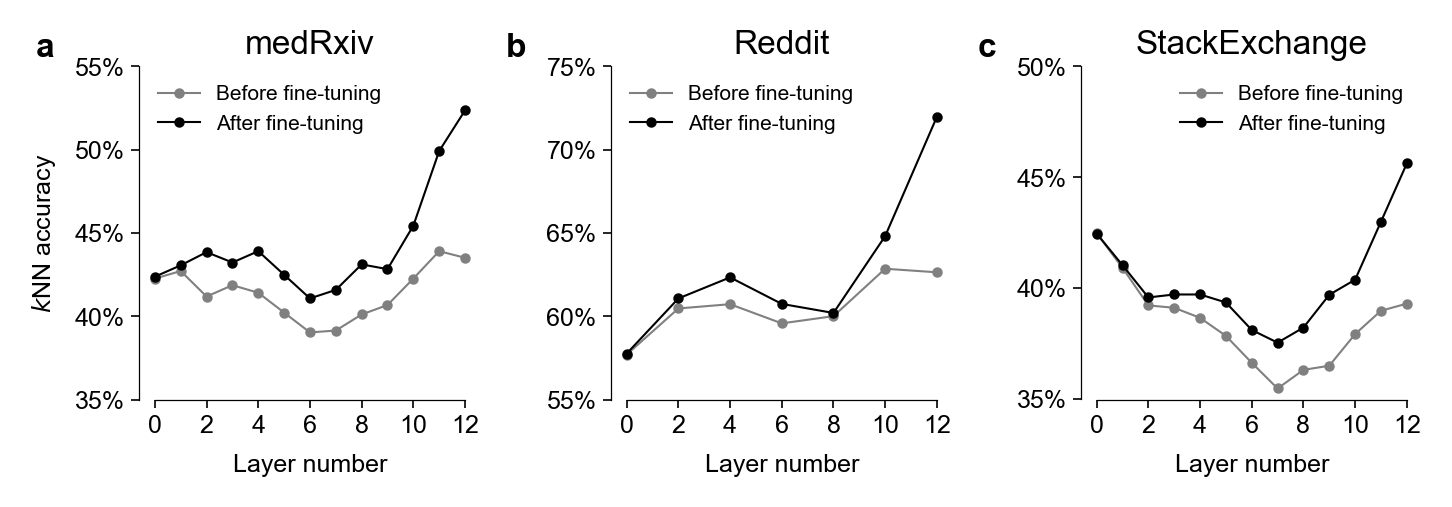

In [ ]:
%matplotlib inline
cm = 1 / 2.54


fig, axs = plt.subplots(
    1, 3, figsize=(12.2 * cm, 4 * cm), dpi=300, layout="constrained"
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

model_name = "MPNet"

# a) MEDRXIV
dataset_name = "medrxiv"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[0].plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[0].plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[0].legend()
axs[0].set_xlabel("Layer number")
axs[0].set_ylabel("$k$NN accuracy")
axs[0].set_title("medRxiv")
axs[0].text(
    -0.25,
    1.1,
    string.ascii_lowercase[0],
    transform=axs[0].transAxes,
    **txtkwargs,
)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].set_yticks(np.arange(0.35, 0.6, 0.05))
axs[0].spines.left.set_bounds(0.35, 0.55)
axs[0].set_xticks(np.arange(0, 14, 2))
axs[0].spines.bottom.set_bounds(
    0,
    12,
)


# b) REDDIT
dataset_name = "reddit"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = (
        f"knn_accuracies_trained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[1].plot(
    np.arange(7) * 2,
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[1].plot(
    np.arange(7) * 2,
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[1].legend()
axs[1].set_xlabel("Layer number")
# axs[1].set_ylabel("kNN accuracy")
axs[1].set_title("Reddit")
axs[1].text(
    -0.25,
    1.1,
    string.ascii_lowercase[1],
    transform=axs[1].transAxes,
    **txtkwargs,
)
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[1].set_yticks(np.arange(0.55, 0.8, 0.05))
axs[1].spines.left.set_bounds(0.55, 0.75)
axs[1].set_xticks(np.arange(0, 14, 2))
axs[1].spines.bottom.set_bounds(
    0,
    12,
)

# c) STACKEXCHANGE
dataset_name = "stackexchange"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

axs[2].plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

axs[2].plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

axs[2].legend()
axs[2].set_xlabel("Layer number")
# axs[2].set_ylabel("kNN accuracy")
axs[2].set_yticks([0.35, 0.40, 0.45])
axs[2].set_title("StackExchange")
axs[2].text(
    -0.25,
    1.1,
    string.ascii_lowercase[2],
    transform=axs[2].transAxes,
    **txtkwargs,
)
axs[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
axs[2].set_yticks(np.arange(0.35, 0.5, 0.05))
axs[2].spines.left.set_bounds(0.35, 0.5)
axs[2].set_xticks(np.arange(0, 14, 2))
axs[2].spines.bottom.set_bounds(
    0,
    12,
)

fig.savefig(figures_path / "figure_S1_ecml_v1.png")
fig.savefig(figures_path / "figure_S1_ecml_v1.pdf")

## Figure S2

In [ ]:
mpl.rcParams["xtick.labelsize"] = 5
mpl.rcParams["ytick.labelsize"] = 5
mpl.rcParams["axes.labelsize"] = 5
mpl.rcParams["axes.titlesize"] = 6

In [ ]:
12.2 * 0.75

9.149999999999999

[0.36923076923076925, 0.49, 0.553076923076923, 0.5553846153846154]
[0.5561538461538461, 0.5738461538461539, 0.5823076923076923, 0.583076923076923, 0.5876923076923077, 0.5869230769230769, 0.5961538461538461, 0.5992307692307692, 0.0823076923076923, 0.08923076923076922, 0.055384615384615386, 0.05076923076923077]


/tmp/ipykernel_455509/1617163641.py:211: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend(loc="upper right")
/tmp/ipykernel_455509/1617163641.py:309: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()


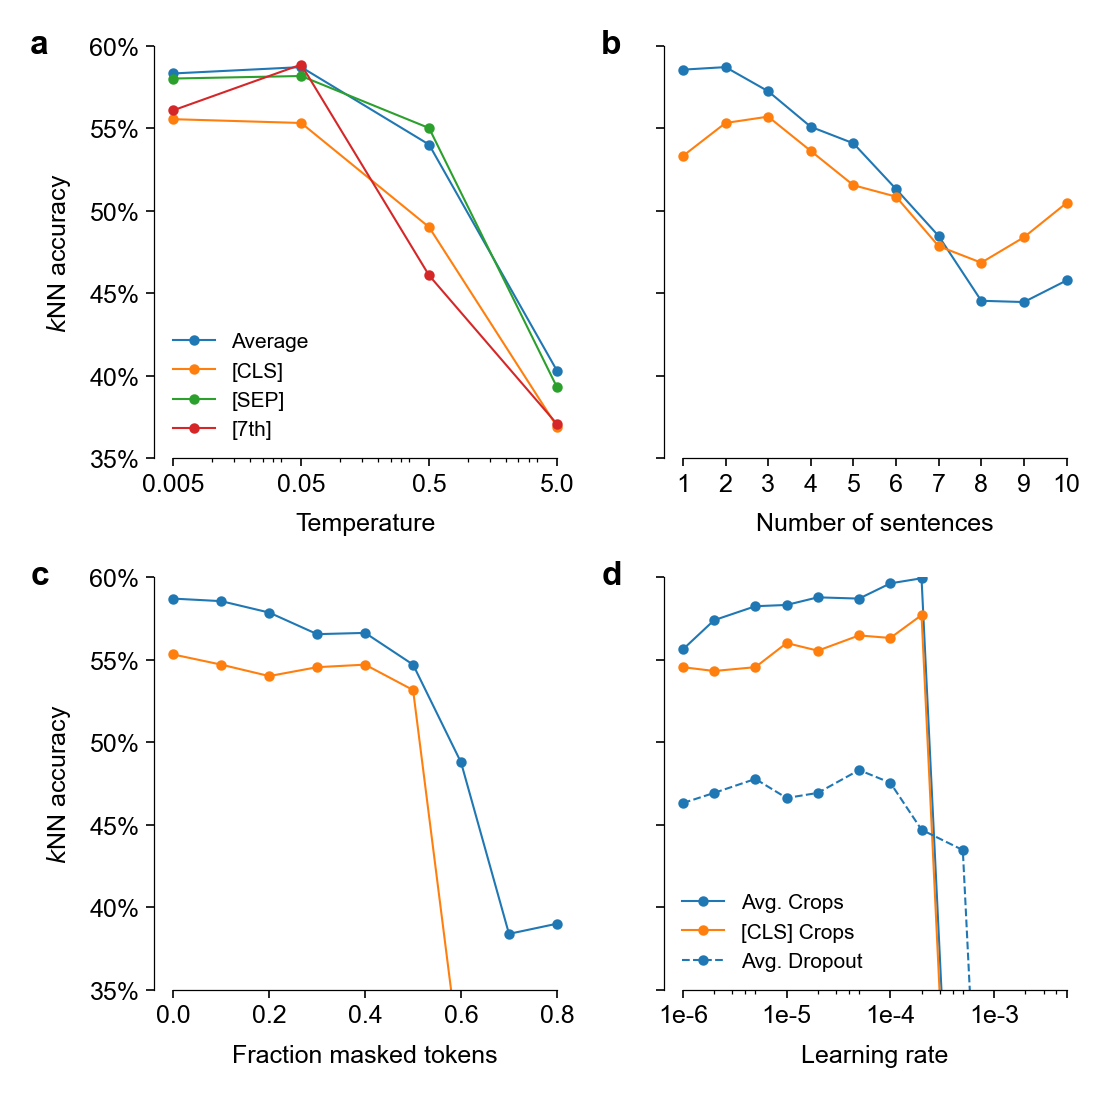

In [ ]:
%matplotlib inline
cm = 1 / 2.54

fig, axs = plt.subplots(
    2,
    2,
    figsize=(9.15 * cm, 9 * cm),
    dpi=300,
    layout="constrained",
    sharey=True,
)
model_name = "MPNet"
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
txtkwargs = dict(size=8, weight="bold", va="top", ha="right")

## TEMPERATURE
## load things
multipliers = np.array([0.01, 0.1, 1, 10])
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
knn_accuracies_sep_all = []
knn_accuracies_7th_all = []

for j, mult in enumerate(multipliers):
    # AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # SEP
    saving_name_accuracies = Path(
        f"knn_accuracies_sep_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_sep = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # 7th
    saving_name_accuracies = Path(
        f"knn_accuracies_7th_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_7th = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])
    knn_accuracies_sep_all.append(knn_accuracies_sep[-1, 2])
    knn_accuracies_7th_all.append(knn_accuracies_7th[-1, 3])

## plot
print(knn_accuracies_cls_all)
s_chosen = 3
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_av_all,
    label=f"Average",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS]",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_sep_all,
    # color="tab:orange",
    label=f"[SEP]",
    ms=s_chosen,
    marker=".",
)
axs[0, 0].plot(
    1 / (multipliers * 20),
    knn_accuracies_7th_all,
    # color="tab:orange",
    label=f"[7th]",
    ms=s_chosen,
    marker=".",
)
## y-axis
axs[0, 0].set_ylim(0.35, 0.6)
axs[0, 0].set_ylabel("$k$NN accuracy")
axs[0, 0].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
axs[0, 0].spines.left.set_bounds(0.35, 0.6)

## x-axis
axs[0, 0].set_xlabel("Temperature")
axs[0, 0].set_xscale("log")

axs[0, 0].xaxis.set_minor_locator(
    ticker.LogLocator(
        base=10.0,
        subs=np.arange(0.1, 0.8, 0.1) * 5,
    )
)
axs[0, 0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


### add ticks
axs[0, 0].set_xticks(1 / (multipliers * 20))
axs[0, 0].set_xticklabels(1 / (multipliers * 20))

### modify spines
axs[0, 0].spines.bottom.set_bounds(
    1 / (multipliers * 20)[-1], 1 / (multipliers * 20)[0]
)

### other
axs[0, 0].legend()
axs[0, 0].text(
    -0.25,
    1.04,
    string.ascii_lowercase[0],
    transform=axs[0, 0].transAxes,
    **txtkwargs,
)


### N_CONS_SENTENCES
## load things
batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]
knn_accuracies_av_all = []
knn_accuracies_cls_all = []

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    batchsize = batch_sizes[j]
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

## plot
# AV
s_chosen = 3
axs[0, 1].plot(
    np.arange(1, 11),
    knn_accuracies_av_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[0, 1].plot(
    np.arange(1, 11),
    knn_accuracies_cls_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)
## x-axis
axs[0, 1].set_xticks(np.arange(1, 11))
axs[0, 1].spines.bottom.set_bounds(1, 10)
axs[0, 1].set_xlabel("Number of sentences")
## y-axis
axs[0, 1].set_ylim(0.35, 0.6)
axs[0, 1].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[0, 1].set_ylabel("kNN accuracy")
axs[0, 0].spines.left.set_bounds(0.35, 0.6)
## general
axs[0, 1].legend(loc="upper right")
axs[0, 1].text(
    -0.1,
    1.04,
    string.ascii_lowercase[1],
    transform=axs[0, 1].transAxes,
    **txtkwargs,
)


## FRACTION MASKED
## load things
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
# fraction = 0
n_cons_sntcs = 2
saving_name_accuracies = Path(
    "knn_accuracies_av_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_av_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)
saving_name_accuracies = Path(
    "knn_accuracies_cls_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_cls_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)
knn_accuracies_av_all.append(knn_accuracies_av_fraction_masked_0[0])
knn_accuracies_cls_all.append(knn_accuracies_cls_fraction_masked_0[1])

fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    # AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    # CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

## plot
s_chosen = 3
axs[1, 0].plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_av_all,
    # label="fraction_masked = " + str(frct),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
axs[1, 0].plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_cls_all,
    # label="fraction_masked = " + str(frct),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)
## y-axis
axs[1, 0].set_ylim(0.35, 0.6)
axs[1, 0].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[1, 0].set_yticks(np.arange(0.25, 0.65, 0.05))
axs[1, 0].spines.left.set_bounds(0.35, 0.6)
axs[1, 0].set_ylabel("$k$NN accuracy")

## x-axis
axs[1, 0].set_xticks(np.arange(0, 1, 0.2))
axs[1, 0].spines.bottom.set_bounds(0, 0.8)
axs[1, 0].set_xlabel("Fraction masked tokens")
## general
axs[1, 0].legend()
axs[1, 0].text(
    -0.25,
    1.04,
    string.ascii_lowercase[2],
    transform=axs[1, 0].transAxes,
    **txtkwargs,
)


### LEARNING RATE
## load things
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
knn_accuracies_av_dropout_all = []
learning_rates = [
    1e-6,
    2e-6,
    5e-6,
    1e-5,
    2e-5,
    5e-5,
    1e-4,
    2e-4,
    5e-4,
    1e-3,
    2e-3,
    5e-3,
]

for j, lr in enumerate(learning_rates):
    # AV
    saving_name_accuracies = Path(
        "knn_accuracies_av_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # CLS
    saving_name_accuracies = Path(
        "knn_accuracies_cls_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    # AV DROPOUT
    saving_name_accuracies = Path(
        "knn_accuracies_av_dropout_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_av_dropout = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])
    knn_accuracies_av_dropout_all.append(knn_accuracies_av_dropout[-1, 0])

## plot
s_chosen = 3
axs[1, 1].plot(
    learning_rates,
    knn_accuracies_av_all,
    label=f"Avg. Crops",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
    clip_on=True,
)
axs[1, 1].plot(
    learning_rates,
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS] Crops",
    ms=s_chosen,
    marker=".",
    clip_on=True,
)
axs[1, 1].plot(
    learning_rates,
    knn_accuracies_av_dropout_all,
    label=f"Avg. Dropout",
    color="tab:blue",
    ms=s_chosen,
    marker=".",
    linestyle="--",
    clip_on=True,
)
## x-axis
axs[1, 1].set_xlabel("Learning rate")
axs[1, 1].set_xscale("log")
### attempt 2
axs[1, 1].xaxis.set_minor_locator(
    ticker.LogLocator(
        base=10.0,
        subs=np.arange(0.1, 0.6, 0.1),
    )
)
axs[1, 1].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[1, 1].set_xticks(
    [
        1e-6,
        1e-5,
        1e-4,
        1e-3,
        5e-3,
    ]
)
axs[1, 1].set_xticklabels(
    [
        "1e-6",
        "1e-5",
        "1e-4",
        "1e-3",
        " ",
    ]
)
# axs[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.0e"))
axs[1, 1].spines.bottom.set_bounds(1e-6, 5e-3)

## y-axis
axs[1, 1].set_ylim(0.35, 0.6)
axs[1, 1].yaxis.set_major_formatter(
    ticker.PercentFormatter(xmax=1, decimals=0)
)
# axs[1, 1].set_ylabel("kNN accuracy")
# axs[1, 1].set_yticks(np.arange(0, 0.7, 0.1))
axs[1, 1].spines.left.set_bounds(0.35, 0.6)

## general
axs[1, 1].text(
    -0.1,
    1.04,
    string.ascii_lowercase[3],
    transform=axs[1, 1].transAxes,
    **txtkwargs,
)
axs[1, 1].legend()
# axs[1, 1].set_title(f"Learning rate")
print(knn_accuracies_av_all)

fig.savefig(figures_path / "figure_S2_ecml_v1.png")
fig.savefig(figures_path / "figure_S2_ecml_v1.pdf")